# Network-TMLE: a simple example
Here, we demonstrate a simple application and simulation study of the targeted maximum likelihood estimator (TMLE) for network-dependent data (network-TMLE). For this example, we use the data generating mechanism of Sofrygin and van der Laan (2017).

There are three variables each individual has: exposure ($A$), outcome ($W$), and the a baseline covariate ($W$). Here, all variables are binary. We also have measured the network with the following adjacency matrix $\mathcal{G}$. For the $n$ units in the network, we define two summary measures:
$$ W_i^s = \sum_{j=1}^n W_j \mathcal{G}_{ij} $$
$$ A_i^s = \sum_{j=1}^n A_j \mathcal{G}_{ij} $$
Now, we can discuss the data generating mechanism for this example
$$ \text{logit}(\Pr(A_i = 1 | W_i, W_i^s)) = -1.2 + 1.5 W_i 0.6 W_i^s $$
$$ \text{logit}(\Pr(Y_i = 1 | A_i, A_i^s, W_i, W_i^s)) = -2.5 + 0.5 A_i + 1.5 A_i^s + 1.5 W_i + 1.5 W_i^s $$
As shown here, $Y_i$ depends on a summary measure (a simple count) of unit $i$'s immediate contacts' exposure and baseline covariate. Therefore, we have network-dependence and need to use network-TMLE to estimate the mean under a policy.

Here, we will consider 3 different policies. All policies are stochastic, in that they assign each unit a probability of exposure between 0 and 1. The policies are $\omega_1 = \Pr^*(A_i) = 0.2$, $\omega_2 = 0.5$, and $\omega_3 = 0.8$. Conditional policies could also be considered, but here we focus on marginal policies.

The following section setups the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

from mossspider import NetworkTMLE
from mossspider.dgm import uniform_network, generate_observed, generate_truth

### Generating example data 

First, we will use `mossspider` to simulate a uniform random graph for us. This network (and the distribution of $W$) will be held as fixed throughout. See details on the estimand for why this is the case.

Here, the uniform network will consist of $n=500$ units with units having degrees of $F_i = \{1,2,3,4\}$. 

In [2]:
G = uniform_network(n=500,          # Number of nodes
                    degree=[1, 4],  # Min and Max degree
                    seed=2022)      # Seed for consistency

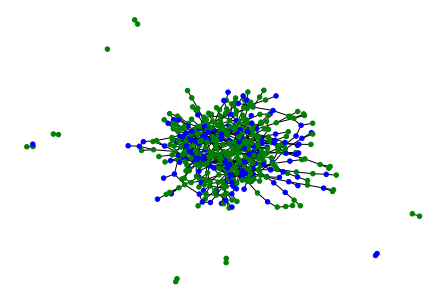

In [3]:
# Generating color map based on W
color_map = []                         # Empty list for colors
for node, data in G.nodes(data=True):  # For loop over nodes
    if data['W'] == 1:                 # If W=1   
        color_map.append('blue')       # ... set color to blue
    else:                              # If W=0
        color_map.append('green')      # ... set color to green

# Drawing the network
nx.draw(G, 
        node_size=20,                  # Setting node size
        node_color=color_map)          # Setting colors

Next, we need to generate some observed values for units' exposure and outcome in the network. We can accomplish this using another built-in function which uses the previous data generating mechanism and adds the exposure data to our network.

In [4]:
H = generate_observed(G, seed=202203)

In [5]:
# Extract A and Y from network
a_list, y_list = [], []
for node, data in G.nodes(data=True):  # For loop over nodes
    a_list.append(data['A'])
    y_list.append(data['Y'])

# Proportions for A and Y
print("A:", np.mean(a_list))
print("Y:", np.mean(y_list))

A: 0.468
Y: 0.646


### Applying Network-TMLE
Now that we have a sample data set, we can apply network-TMLE to it. In `targentula`, network-TMLE is implemented in the `NetworkTMLE` class. To initialize the class object, we need to provide it a `networkx.Graph` with all the assigned variables (done internally by functions used to generate data), the name of the exposure variable, and the name of the outcome variable. We can do this via:

In [6]:
ntmle = NetworkTMLE(network=H,     # NetworkX graph
                    exposure='A',  # Exposure in graph
                    outcome='Y')   # Outcome in graph

Internally, `NetworkTMLE` extracts the adjacency matrix from the network, extracts the variables aligned with the adjacency matrix, and calculates the available summary measures. We can view the generated data set like so

In [7]:
ntmle.df  # Peaking at the generated data set

W  A  Y  _original_id_  W_sum  W_mean  W_var  W_mean_dist  W_var_dist  \
0    0  0  1              0      0     0.0   0.00          0.0        0.00   
1    0  1  1              1      0     0.0   0.00          0.0        0.00   
2    1  0  0              2      0     0.0   0.00         -1.0        0.00   
3    0  0  0              3      0     0.0   0.00          0.0        0.00   
4    0  1  1              4      1     1.0   0.00          1.0        0.00   
..  .. .. ..            ...    ...     ...    ...          ...         ...   
495  1  1  0            495      0     0.0   0.00         -1.0        0.00   
496  1  0  1            496      1     0.5   0.25         -0.5        0.25   
497  0  0  0            497      0     0.0   0.00          0.0        0.00   
498  0  1  0            498      0     0.0   0.00          0.0        0.00   
499  1  1  1            499      0     0.0   0.00         -1.0        0.00   

     A_sum    A_mean     A_var  A_mean_dist  A_var_dist  A_map1  A_map2  \
0        2  0.666667  0.222222     0.666667    0.222222     1.0     0.0   
1        1  1.000000  0.000000     0.000000    0.000000     1.0     0.0   
2        1  0.333333  0.222222     0.333333    0.222222     1.0     0.0   
3        0  0.000000  0.000000     0.000000    0.000000     0.0     0.0   
4        1  1.000000  0.000000     0.000000    0.000000     1.0     0.0   
..     ...       ...       ...          ...         ...     ...     ...   
495      1  0.333333  0.222222    -0.666667    0.222222     0.0     0.0   
496      1  0.500000  0.250000     0.500000    0.250000     0.0     1.0   
497      2  1.000000  0.000000     1.000000    0.000000     1.0     1.0   
498      0  0.000000  0.000000    -1.000000    0.000000     0.0     0.0   
499      0  0.000000  0.000000    -1.000000    0.000000     0.0     0.0   

     A_map3  A_map4  degree  __degree_flag__  
0       1.0     0.0       3                0  
1       0.0     0.0       1                0  
2       0.0     0.0       3                0  
3       0.0     0.0       1                0  
4       0.0     0.0       1                0  
..      ...     ...     ...              ...  
495     1.0     0.0       3                0  
496     0.0     0.0       2                0  
497     0.0     0.0       2                0  
498     0.0     0.0       1                0  
499     0.0     0.0       1                0  

[500 rows x 20 columns]

The next step of applying network-TMLE is to specify the nuisance models.

#### Nuisance Models

##### Exposure Nuisance Model

To start, we will specify the exposure nuisance models. The exposure nuisance models are used to estimate the inverse probability weights (IPW). IPW take the following form
$$ \frac{\pi^*(W_i,W_i^s, \delta^*, \gamma^*)}{\pi(W_i,W_i^s, \delta, \gamma)} = \frac{\Pr(A_i,A_i^s | W_i, W_i^s; \delta^*, \gamma^*)}{\Pr(A_i,A_i^s | W_i, W_i^s; \delta, \gamma)} $$
To make this simpler, we factor the probabilities as
$$ \frac{\pi^*(W_i,W_i^s, \delta^*, \gamma^*)}{\pi(W_i,W_i^s, \delta, \gamma)} = \frac{\Pr(A_i, | W_i, W_i^s; \delta^*) \Pr(A_i, | A_i, W_i, W_i^s; \gamma^*)}{\Pr(A_i | W_i, W_i^s; \delta) \Pr(A_i^s | A_i, W_i, W_i^s; \gamma)} $$
Therefore, there are (at least) two models to estimate. For now, we just need to specify the parametric model with network-TMLE.

To specify the exposure nuisance model, we actually need to specify two separate models here. We can do this via

In [8]:
# Model for Pr(A | W, W^s; \delta)
ntmle.exposure_model(model="W + W_sum")          # Parametric model

# Model for Pr(A^s | A, W, W^s; \gamma)
ntmle.exposure_map_model(model='A + W + W_sum',  # Parametric model
                         measure='sum',          # Summary measure for A^s
                         distribution='poisson') # Model distribution to use

For the `.exposure_map_model`, you will notice there are two additional arguments. This tells `NetworkTMLE` two key pieces of information: the summary measure to use for $A^s$ and the distribution to use for the model. Here, we are telling `NetworkTMLE` to use the `'A_sum'` measure ($\sum_{j=1}^n A_j \mathcal{G}_{ij}$) and to use a Poisson GLM (since `'A_sum'` is a count variable). 

##### Outcome Nuisance Model

Next, we need to specify the outcome nuisance model. Unlike the exposure nuisance model, we don't need to factor. Instead, we use a single model for 
$$E[Y_i | A_i, A_i^s, W_i, W_i^s; \alpha]$$
We can specify the parametric form of this model via

In [9]:
# Model for E[Y | A, A^s, W, W^s; \alpha]
ntmle.outcome_model(model='A + A_sum + W + W_sum')

#### Targeting and Evaluation
Now that our nuisance models are defined, we can now estimate parameter of interest. This is all done via the `.fit()` function. However, the `.fit()` function is doing a lot behind the scenes. First, the IPW are calculated. The numerator for these weights is done using a simulation approach. Next the outcome model are targeted via IPW. Then the outcome model is used to generate predictions under the policy and are subsequently targeted. Because stochastic policies have randomness, we handle the randomness with a Monte Carlo integration procedure. Lastly, we calculate the variance and confidence intervals using the influence curve.

To begin, we will estimate the mean under $\omega_1$. Here, we will use 500 samples for the IPW estimation and the Monte Carlo integration (in general, the larger the number of samples the better the approximation)

In [10]:
# Estimation
ntmle.fit(p=0.2,          # Policy
          samples=500,    # replicates for MC integration
          seed=20220316)  # seed for consistency

# Displaying results
ntmle.summary(decimal=4)

            Network Targeted Maximum Likelihood Estimator             
Treatment:        A               No. Observations:     500                 
Outcome:          Y               No. Background Nodes: 0                   
Q-Model:          Logistic        No. IPW Truncated:    0                   
g-Model:          Logistic        No. Resamples:        500                 
gs-Model:         Poisson         g-Distribution:       Poisson             
Mean under policy:       0.4404
----------------------------------------------------------------------
Variance Estimates
----------------------------------------------------------------------
Conditional: Direct-Only
SE      :      0.022
95.0% CL:     [0.3972 0.4836]
Conditional: Direct & Latent
SE      :      0.0217
95.0% CL:     [0.3979 0.483 ]


We can repeat the same process for the other $\omega$

In [11]:
# Estimation
ntmle.fit(p=0.5,         # Policy
          samples=500,  # replicates for MC integration
          seed=2022)     # seed for consistency

# Displaying results
ntmle.summary(decimal=4)

            Network Targeted Maximum Likelihood Estimator             
Treatment:        A               No. Observations:     500                 
Outcome:          Y               No. Background Nodes: 0                   
Q-Model:          Logistic        No. IPW Truncated:    0                   
g-Model:          Logistic        No. Resamples:        500                 
gs-Model:         Poisson         g-Distribution:       Poisson             
Mean under policy:       0.6713
----------------------------------------------------------------------
Variance Estimates
----------------------------------------------------------------------
Conditional: Direct-Only
SE      :      0.0166
95.0% CL:     [0.6387 0.7038]
Conditional: Direct & Latent
SE      :      0.0162
95.0% CL:     [0.6395 0.7031]


In [12]:
# Estimation
ntmle.fit(p=0.8,         # Policy
          samples=500,  # replicates for MC integration
          seed=2022)     # seed for consistency

# Displaying results
ntmle.summary(decimal=4)

            Network Targeted Maximum Likelihood Estimator             
Treatment:        A               No. Observations:     500                 
Outcome:          Y               No. Background Nodes: 0                   
Q-Model:          Logistic        No. IPW Truncated:    0                   
g-Model:          Logistic        No. Resamples:        500                 
gs-Model:         Poisson         g-Distribution:       Poisson             
Mean under policy:       0.8281
----------------------------------------------------------------------
Variance Estimates
----------------------------------------------------------------------
Conditional: Direct-Only
SE      :      0.0153
95.0% CL:     [0.7981 0.8582]
Conditional: Direct & Latent
SE      :      0.015
95.0% CL:     [0.7987 0.8575]


As the assigned probability under $\omega$ increased, the mean became larger here. Therefore, if $Y$ was a beneficial outcome, we would prefer policies that increased $A$. If $Y$ was instead harmful, we would prefer policies where $A$ was mitigated. 

### Simulation
As a quick demonstration of the performance of network-TMLE, we now conduct a simulation study using the same mechanism and evaluating at the same $\omega$. First, we will simulate the truth or reference values. This can easily be done using a built-in function

In [13]:
# Setup values to evaluate at
omega = [0.2, 0.5, 0.8]
truth = {}

# Calculate truth or reference values
for p in omega:                      # For every omega
    true_p = []                      # Empty storage
    for i in range(5000):           # Sim 10k times
        y_mean = generate_truth(graph=G, p=p)
        true_p.append(y_mean)
    truth[p] = np.mean(true_p)       # update dict to have true


print(truth)

{0.2: 0.4929396000000001, 0.5: 0.665762, 0.8: 0.7947992}


Now we can generate a bunch of observations, run network-TMLE on each iteration, and the evaluate the bias and confidence interval coverage. Here, 200 simulations are done for the previously generated network

In [14]:
# Setup simulation result storage
bias, coverage = {}, {}
for p in omega:
    bias[p] = []
    coverage[p] = []

# Running the simulation
for i in range(200):
    # Generating A & Y data for the observational mechanism
    K = generate_observed(G, seed=None)  # seed is None, so changes each iteration
    
    # Specifying network-TMLE
    ntmle = NetworkTMLE(network=K,                      # NetworkX graph
                    exposure='A',                       # Exposure
                    outcome='Y')                        # Outcome
    ntmle.exposure_model(model="W + W_sum")             # Parametric model
    ntmle.exposure_map_model(model='A + W + W_sum',     # Parametric model
                             measure='sum',             # A^s specification
                             distribution='poisson')    # Model distribution
    ntmle.outcome_model(model='A + A_sum + W + W_sum')  # Parametric model
    
    # Estimating the mean and confidence intervals for each policy
    for p in omega:
        ntmle.fit(p=p,    # Policy
          samples=500)    # replicates
        bias[p].append(ntmle.marginal_outcome - truth[p])
        ci = ntmle.conditional_latent_ci
        if ci[0] < truth[p] < ci[1]:
            coverage[p].append(1)
        else:
            coverage[p].append(0)


In [15]:
print("Results")
print("=======================")
for p in omega:
    print("-----------------------")
    print("Omega:   ", p)
    print("Bias:    ", np.round(np.mean(bias[p]), 3))
    print("Coverage:", np.round(np.mean(coverage[p]), 3))
print("=======================")

Results
-----------------------
Omega:    0.2
Bias:     -0.002
Coverage: 0.805
-----------------------
Omega:    0.5
Bias:     -0.001
Coverage: 0.95
-----------------------
Omega:    0.8
Bias:     -0.0
Coverage: 0.945


As seen here, estimates have little bias for each $\omega$. However, confidence interval coverage is a little low. This may improve as the number of simulation iterations increase. Alternatively, the $n$ may be too small to extrapolate to the $\omega_1$ policy based on the observed data.